In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

## The gamma distribution

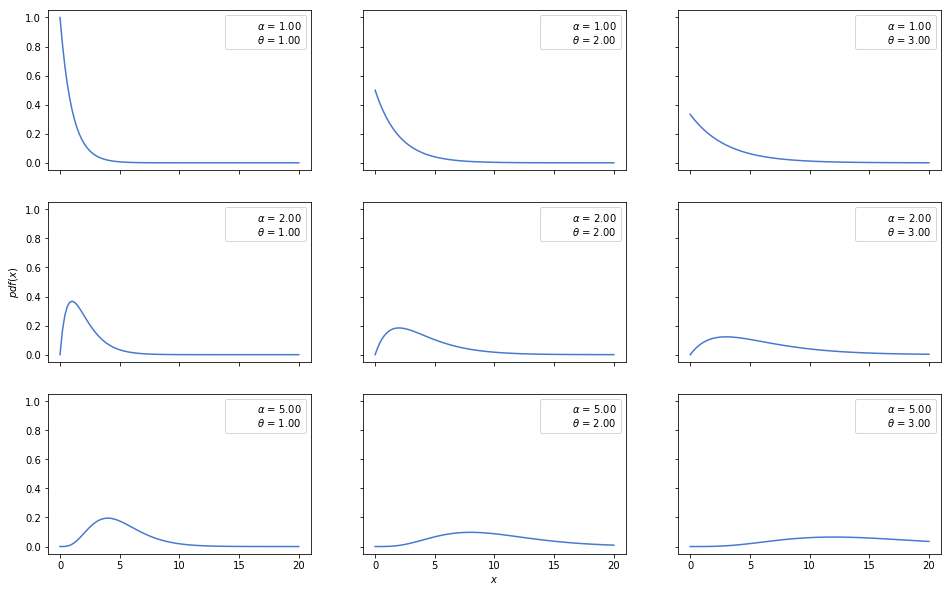

In [2]:
rates = [1, 2, 5]
scales = [1, 2, 3]

x = np.linspace(0, 20, 100)
f, ax = plt.subplots(len(rates), len(scales), sharex=True, sharey=True, figsize=(16,10));
for i in range(len(rates)):
    for j in range(len(scales)):
        rate = rates[i]
        scale = scales[j]
        rv = stats.gamma(a=rate, scale=scale)
        ax[i,j].plot(x, rv.pdf(x));
        ax[i,j].plot(0, 0, 
        label="$\\alpha$ = {:3.2f}\n$\\theta$ = {:3.2f}".format(rate, scale), alpha=0);
        ax[i,j].legend();
ax[2,1].set_xlabel('$x$');
ax[1,0].set_ylabel('$pdf(x)$');

## Simple linear regression

In [3]:
np.random.seed(1)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x 
y = y_real + eps_real

# we can center the data
#x = x - x.mean()
# or standardize the data
#x = (x - x.mean())/x.std()
#y = (y - y.mean())/y.std()

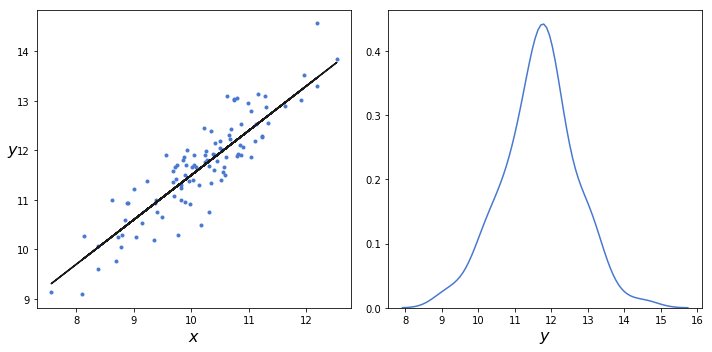

In [4]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x, y, 'b.')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x, y_real, 'k')
plt.subplot(1,2,2)
sns.kdeplot(y)
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()

In [5]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = pm.Deterministic('mu', alpha + beta * x)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    start = pm.find_MAP() 
    step = pm.Metropolis() 
    trace = pm.sample(10000, step, start, njobs=1)

/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -66.676, ||grad|| = 48.412: 100%|██████████| 38/38 [00:00<00:00, 2960.26it/s]         
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [beta]
>Metropolis: [alpha]
100%|██████████| 10500/10500 [00:02<00:00, 3926.04it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


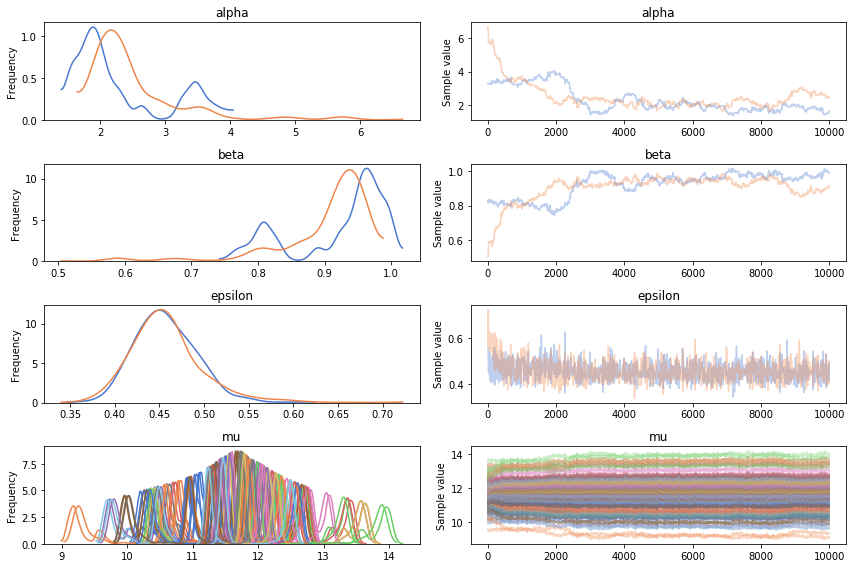

In [6]:
pm.traceplot(trace);

In [7]:
#pm.summary(trace)

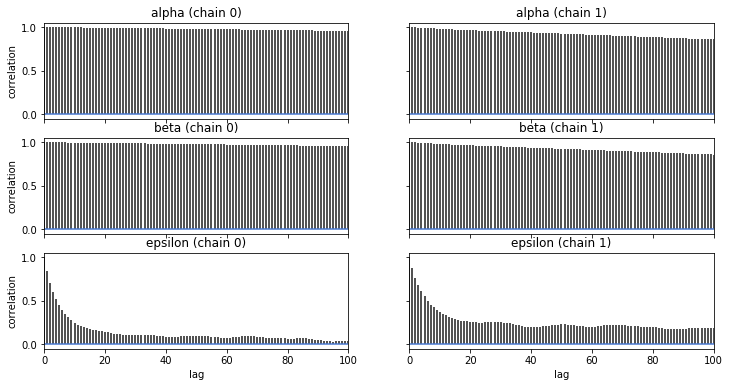

In [8]:
varnames = ['alpha', 'beta', 'epsilon']
pm.autocorrplot(trace, varnames);

#### We have a bad model we bad mixing and lots of autocorrelation for $\alpha$ and $\beta$. This is because $\alpha$ and $\beta$ are correlated by definition since no matter what line we fit on our data it needs to pass through the means of $y$ and $x$. So if that's true we are essentially spinning a line around the means of $x$ and $y$, thus an increase in the slope $\beta$ means a decrease in the intercept $\alpha$. This is obvious from the join probability distribution below how correlated they are.

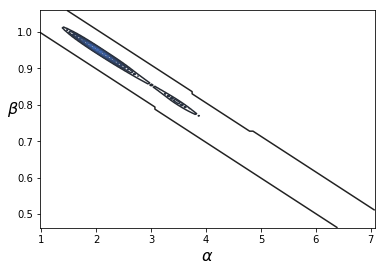

In [9]:
sns.kdeplot(trace['alpha'], trace['beta']);
plt.xlabel(r'$\alpha$', fontsize=16);
plt.ylabel(r'$\beta$', fontsize=16, rotation=0);

#### To fix this we could centre the data before fitting (see commented code in the creation of the data above) or change our sampling method.

### Changing the sampling method

In [10]:
with pm.Model() as model_n:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = pm.Deterministic('mu', alpha + beta * x)

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    start = pm.find_MAP() 
    step = pm.NUTS() 
    trace_n = pm.sample(2000, step=step, start=start,njobs=1)

/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -66.676, ||grad|| = 48.412: 100%|██████████| 38/38 [00:00<00:00, 3378.42it/s]         
Sequential sampling (2 chains in 1 job)
NUTS: [epsilon, beta, alpha]
100%|██████████| 2500/2500 [00:08<00:00, 291.06it/s]


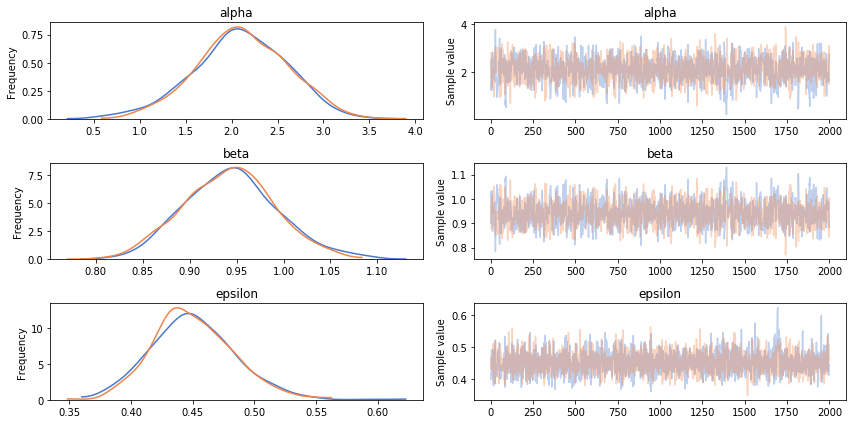

In [11]:
pm.traceplot(trace_n, varnames);

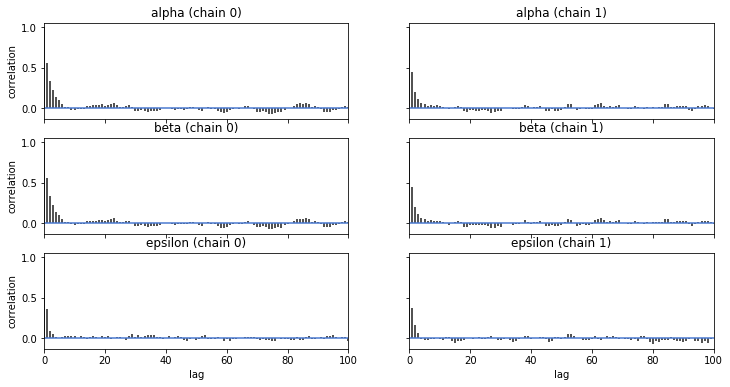

In [12]:
pm.autocorrplot(trace_n, varnames);

In [13]:
pm.summary(trace_n, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,2.10,0.50,1.45e-02,1.11,3.07,1161.16,1.0
beta,0.94,0.05,1.43e-03,0.85,1.04,1148.15,1.0
epsilon,0.45,0.03,7.68e-04,0.38,0.51,1915.53,1.0


### Posterior predictive checks

In [14]:
ppc = pm.sample_ppc(trace_n, samples=231, model=model_n)

/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 231/231 [00:00<00:00, 2143.68it/s]


/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


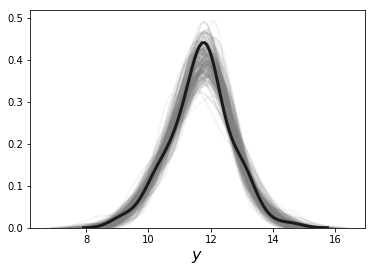

In [15]:
# predicted data
for y_tilde in ppc['y_pred']:
    sns.kdeplot(y_tilde, alpha=0.1, c='gray')
# actual data
sns.kdeplot(y, linewidth=3, color='k')
plt.xlabel('$y$', fontsize=16);

## Interpreting the posterior

### Plot the mean estimates of the model parameters

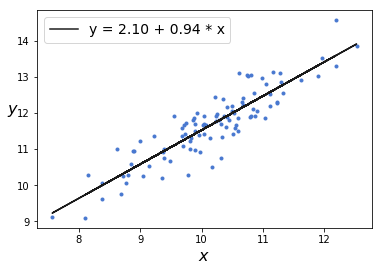

In [16]:
plt.plot(x, y, 'b.');
alpha_m = trace_n['alpha'].mean()
beta_m = trace_n['beta'].mean()
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m));
plt.xlabel('$x$', fontsize=16);
plt.ylabel('$y$', fontsize=16, rotation=0);
plt.legend(loc=2, fontsize=14);

### Plot the a sample of the lines from the parameters and the mean estimates

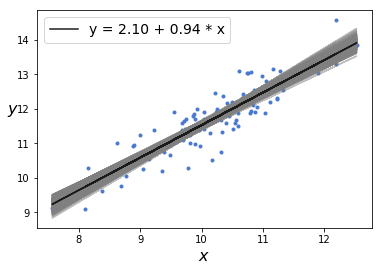

In [17]:
plt.plot(x, y, 'b.');

idx = range(0, len(trace_n['alpha']), 10)
plt.plot(x, trace_n['alpha'][idx] + trace_n['beta'][idx] *  x[:,np.newaxis], c='gray', alpha=0.5);

plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m));

plt.xlabel('$x$', fontsize=16);
plt.ylabel('$y$', fontsize=16, rotation=0);
plt.legend(loc=2, fontsize=14);

### Plot the the HPD98% lines and the mean estimates

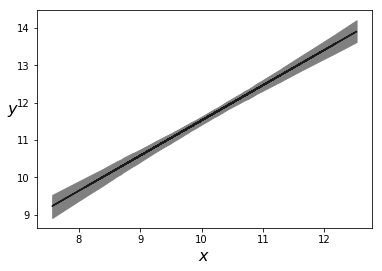

In [18]:
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

idx = np.argsort(x)
x_ord = x[idx]
# note that `mu` is the deterministic variable that corresponds to the mean of the model 
# (i.e. y_pred without the noise)
sig = pm.hpd(trace_n['mu'], alpha=.02)[idx]
plt.fill_between(x_ord, sig[:,0], sig[:,1], color='gray');

plt.xlabel('$x$', fontsize=16);
plt.ylabel('$y$', fontsize=16, rotation=0);

In [19]:
ppc = pm.sample_ppc(trace_n, samples=1000, model=model_n)

/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 1000/1000 [00:00<00:00, 2792.48it/s]


### Plot the the HPD95% lines of the prediction (y_pred) and the mean estimates

Text(0, 0.5, '$y$')

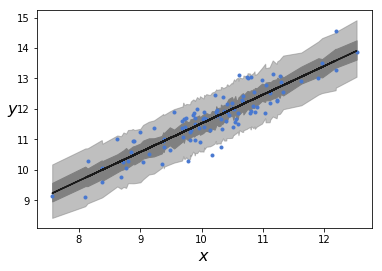

In [20]:
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

# note y_pred includes the noise (vs mu that doesn't)
# note that idx is used to order the samples according to the order of x
sig0 = pm.hpd(ppc['y_pred'], alpha=0.5)[idx]
sig1 = pm.hpd(ppc['y_pred'], alpha=0.05)[idx]
plt.fill_between(x_ord, sig0[:,0], sig0[:,1], color='gray', alpha=1)
plt.fill_between(x_ord, sig1[:,0], sig1[:,1], color='gray', alpha=0.5)

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)

## Pearson correlation coefficient

In [21]:
with pm.Model() as model_n:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = alpha + beta * x
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    # coefficient of determination, i.e. r^2 can be calculated like this 
    rb = pm.Deterministic('rb', (beta * x.std() / y.std()) ** 2)
    # or like this `rss` 
    y_mean = y.mean()
    ss_reg = pm.math.sum((mu - y_mean) ** 2)
    ss_tot = pm.math.sum((y - y_mean) ** 2)
    rss = pm.Deterministic('rss', ss_reg/ss_tot)

    start = pm.find_MAP()
    step = pm.NUTS()
    trace_n = pm.sample(2000, step=step, start=start,njobs=1)

/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -66.676, ||grad|| = 48.412: 100%|██████████| 38/38 [00:00<00:00, 4219.96it/s]         
Sequential sampling (2 chains in 1 job)
NUTS: [epsilon, beta, alpha]
100%|██████████| 2500/2500 [00:08<00:00, 302.33it/s]


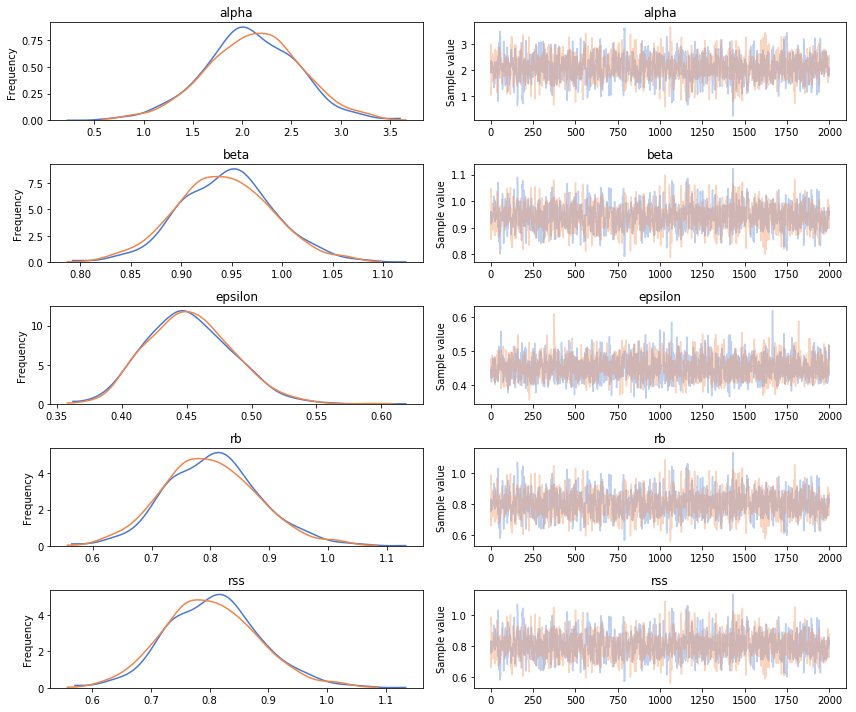

In [22]:
pm.traceplot(trace_n);

In [23]:
pm.summary(trace_n)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,2.09,0.48,1.20e-02,1.13,3.03,1231.79,1.0
beta,0.94,0.05,1.17e-03,0.85,1.04,1230.75,1.0
epsilon,0.45,0.03,7.54e-04,0.39,0.51,1728.19,1.0
rb,0.80,0.08,1.99e-03,0.65,0.97,1228.96,1.0
rss,0.80,0.08,2.00e-03,0.65,0.96,1228.58,1.0


### The multivariate normal distribution 
Actualy the bivariate

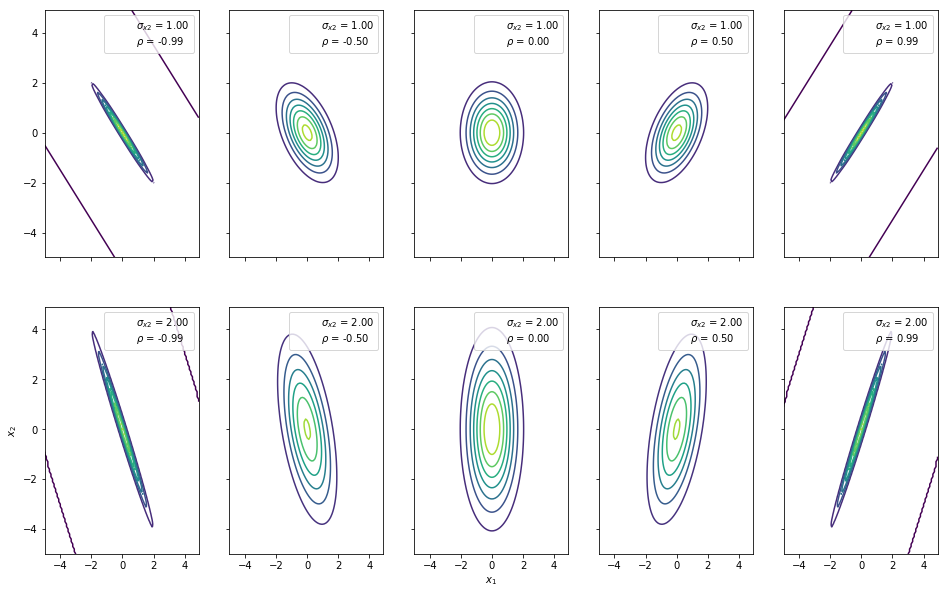

In [24]:
sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.99, -0.5, 0, 0.5, 0.99]

k, l = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.empty(k.shape + (2,))
pos[:, :, 0] = k; pos[:, :, 1] = l

f, ax = plt.subplots(len(sigmas_x2), len(rhos), sharex=True, sharey=True)
#f.figure(figsize=(5, 1))
for i in range(2):
    for j in range(5):
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho], [sigma_x1*sigma_x2*rho, sigma_x2**2]]
        rv = stats.multivariate_normal([0, 0], cov)
        ax[i,j].contour(k, l, rv.pdf(pos))
        ax[i,j].plot(0, 0, 
        label="$\\sigma_{{x2}}$ = {:3.2f}\n$\\rho$ = {:3.2f}".format(sigma_x2, rho), alpha=0)
        ax[i,j].legend()
ax[1,2].set_xlabel('$x_1$')
ax[1,0].set_ylabel('$x_2$')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)

In [25]:
data = np.stack((x, y)).T
print('Stacked x(column 1) and y(column 2): \n{}'.format(data[:5,:]))

Stacked x(column 1) and y(column 2): 
[[ 9.55 11.91]
 [11.22 12.3 ]
 [10.4  11.6 ]
 [10.59 11.5 ]
 [ 8.91 10.95]]


In [26]:
with pm.Model() as pearson_model:
    # 2-d vector of the means of each variable
    # we initialise at the calculated means from the data (data.mean(axis=0))
    mu = pm.Normal('mu', mu=data.mean(axis=0), sd=10, shape=2)
    # priors on the elements that make up the covariance matrix
    # there are other ways of putting a prior on a covariance matrix
    # see page 112 of the book
    sigma_1 = pm.HalfNormal('simga_1', 10)
    sigma_2 = pm.HalfNormal('sigma_2', 10)
    rho = pm.Uniform('rho', -1, 1)
    
    cov = pm.math.stack(([sigma_1**2, sigma_1*sigma_2*rho], [sigma_1*sigma_2*rho, sigma_2**2]))
    
    y_pred = pm.MvNormal('y_pred', mu=mu, cov=cov, observed=data)
    
#     start = pm.find_MAP()
    step = pm.NUTS()#scaling=start
    trace_p = pm.sample(1000, step=step, start=start, njobs=1)

/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead

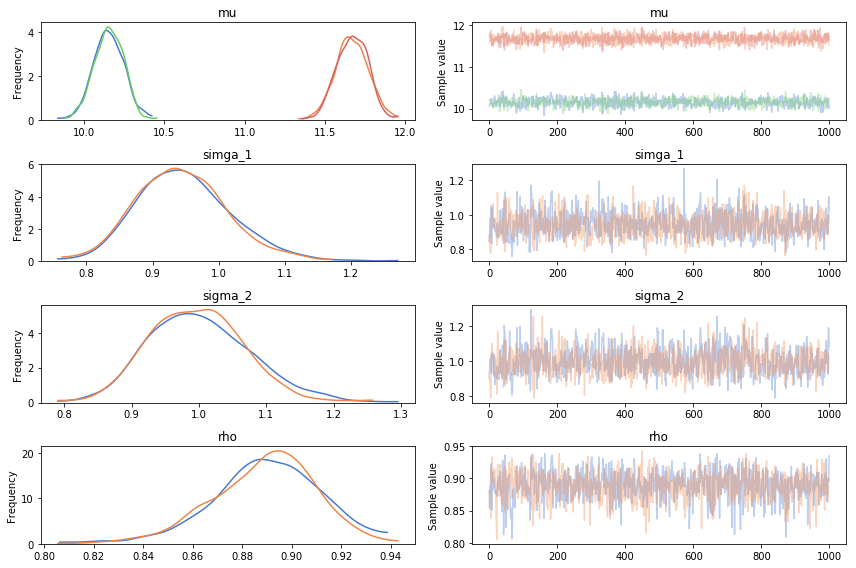

In [27]:
pm.traceplot(trace_p);

In [28]:
print(pm.summary(trace_p))
print('R^2 = {:.2f}'.format(np.square(trace_p['rho'].mean()))+ ' (for comparison with previous)')

          mean    sd  mc_error  hpd_2.5  hpd_97.5    n_eff  Rhat
mu__0    10.15  0.09  2.58e-03     9.96     10.32  1123.01   1.0
mu__1    11.67  0.10  2.65e-03    11.48     11.85  1092.48   1.0
simga_1   0.95  0.07  2.11e-03     0.82      1.08  1063.89   1.0
sigma_2   1.00  0.07  2.33e-03     0.86      1.14   921.04   1.0
rho       0.89  0.02  6.92e-04     0.85      0.93  1118.32   1.0
R^2 = 0.79 (for comparison with previous)


## Robust linear regression

In [29]:
ans = sns.load_dataset('anscombe')
x_3 = ans[ans.dataset == 'III']['x'].values
y_3 = ans[ans.dataset == 'III']['y'].values

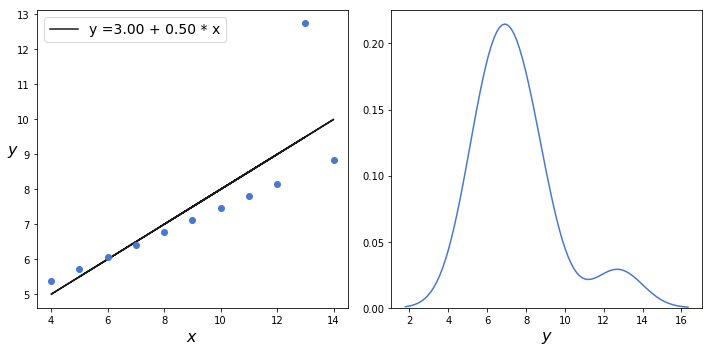

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
plt.plot(x_3, (alpha_c + beta_c* x_3), 'k', label='y ={:.2f} + {:.2f} * x'.format(alpha_c, beta_c))
plt.plot(x_3, y_3, 'bo')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.subplot(1,2,2)
sns.kdeplot(y_3);
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()

In [31]:
with pm.Model() as model_t:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Deterministic('nu', pm.Exponential('nu_', 1/29) + 1)
    
    y_pred = pm.StudentT('y_pred', mu=alpha + beta * x_3, sd=epsilon, nu=nu, observed=y_3)

    # start = pm.find_MAP() -> pymc3 warns against using MAP to initialise NUTS
    step = pm.NUTS() #scaling=start
    trace_t = pm.sample(2000, step=step, start=start, njobs=1)

Sequential sampling (2 chains in 1 job)
NUTS: [nu_, epsilon, beta, alpha]
100%|██████████| 2500/2500 [00:10<00:00, 230.80it/s]
The acceptance probability does not match the target. It is 0.8922604997825845, but should be close to 0.8. Try to increase the number of tuning steps.


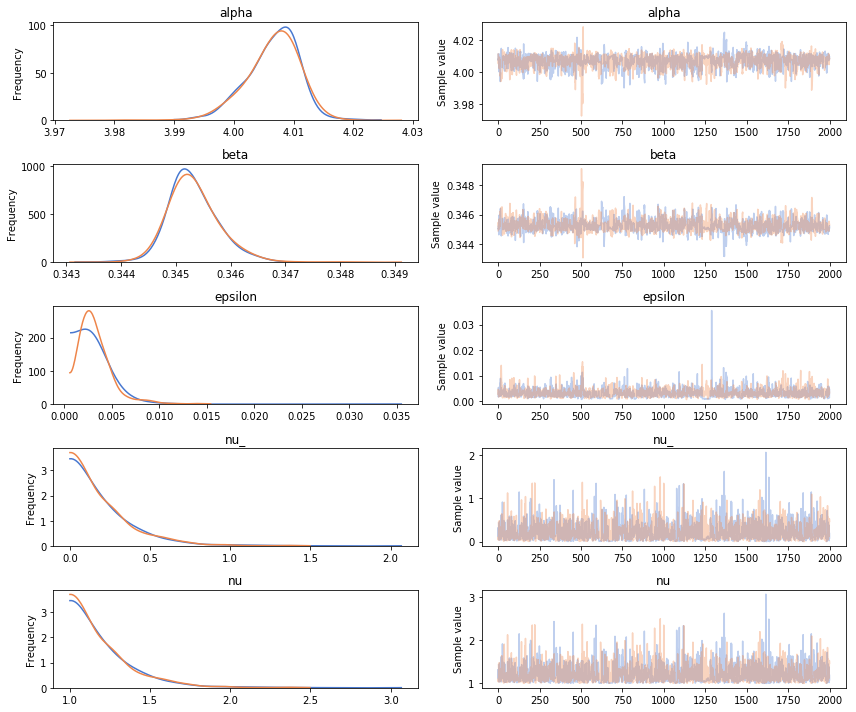

In [32]:
pm.traceplot(trace_t);

In [33]:
pm.summary(trace_t)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,4.01e+00,4.38e-03,1.31e-04,4.00e+00,4.01e+00,1035.04,1.0
beta,3.45e-01,4.55e-04,1.37e-05,3.45e-01,3.46e-01,1069.23,1.0
epsilon,3.24e-03,1.79e-03,5.53e-05,6.67e-04,6.39e-03,1114.93,1.0
nu_,2.11e-01,2.09e-01,4.23e-03,7.57e-05,6.20e-01,2590.24,1.0
nu,1.21e+00,2.09e-01,4.23e-03,1.00e+00,1.62e+00,2590.24,1.0


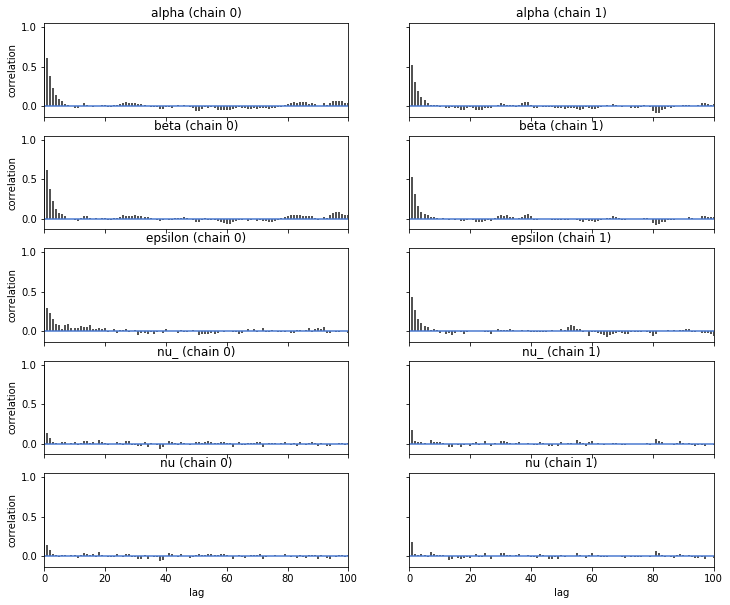

In [34]:
pm.autocorrplot(trace_t);

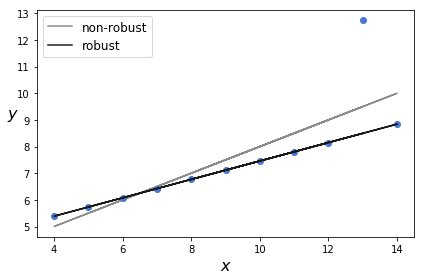

In [35]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'bo')
alpha_m = trace_t['alpha'].mean()
beta_m = trace_t['beta'].mean()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=2, fontsize=12)
plt.tight_layout()

In [36]:
ppc = pm.sample_ppc(trace_t, samples=200, model=model_t, random_seed=2)

/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 200/200 [00:00<00:00, 1524.18it/s]


/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


Text(0.5, 0, '$y$')

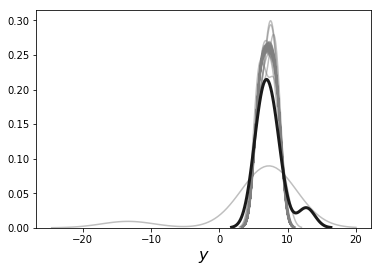

In [37]:
# predicted data
for y_tilde in ppc['y_pred']:
    sns.kdeplot(y_tilde, alpha=0.5, c='gray')

# actual data
sns.kdeplot(y_3, linewidth=3, color='k')
plt.xlabel('$y$', fontsize=16)

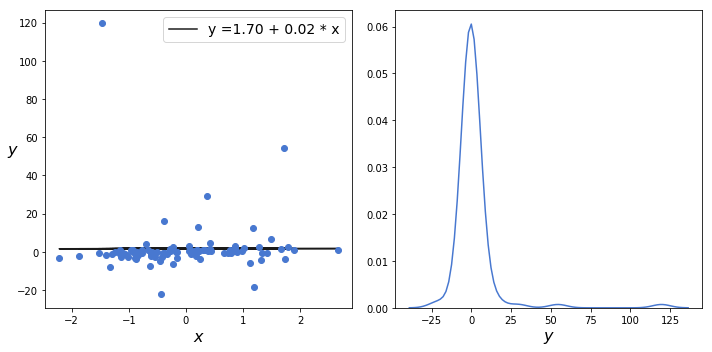

In [38]:
np.random.seed(314)
x_4 = np.random.normal(size=100)
y_4 = x_4 + np.random.standard_t(df=1, size=100) # experiments with different values of df

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
beta_c, alpha_c = stats.linregress(x_4, y_4)[:2]
plt.plot(x_4, (alpha_c + beta_c* x_4), 'k', label='y ={:.2f} + {:.2f} * x'.format(alpha_c, beta_c))
plt.plot(x_4, y_4, 'bo')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.subplot(1,2,2)
sns.kdeplot(y_4);
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()

In [39]:
with pm.Model() as model_t2:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)
    #nu = pm.Gamma('nu', mu=20, sd=15)
    #nu = pm.Gamma('nu', 2, 0.1)

    
    y_pred = pm.StudentT('y_pred', mu=alpha + beta * x_4, sd=epsilon, nu=nu, observed=y_4)

#     start = pm.find_MAP()
    step = pm.NUTS() #scaling=start
    trace_t2 = pm.sample(2000, step=step, start=start,njobs=1,chains=1)

Sequential sampling (1 chains in 1 job)
NUTS: [nu, epsilon, beta, alpha]
100%|██████████| 2500/2500 [00:02<00:00, 1113.72it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


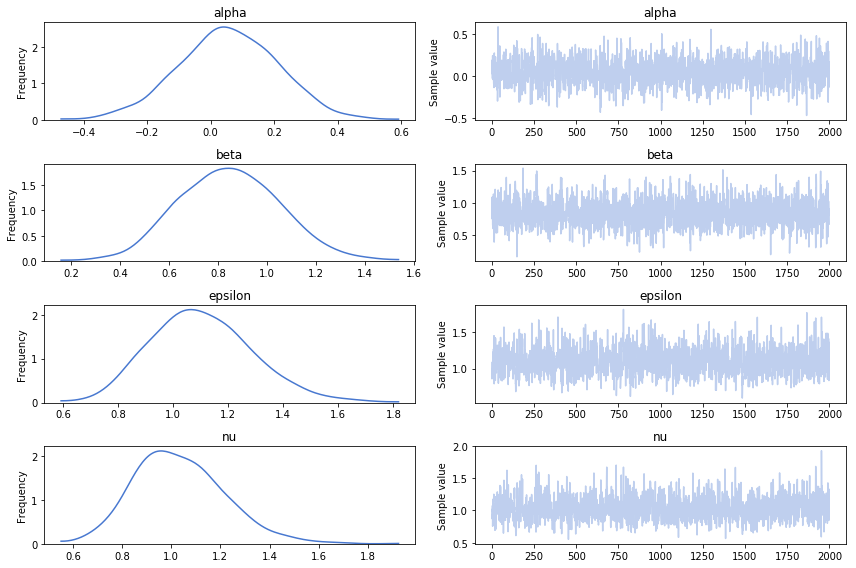

In [40]:
pm.traceplot(trace_t2);

In [41]:
pm.summary(trace_t2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,0.05,0.15,3.23e-03,-0.27,0.33
beta,0.84,0.21,4.84e-03,0.44,1.24
epsilon,1.10,0.18,4.96e-03,0.76,1.46
nu,1.03,0.18,4.84e-03,0.69,1.39


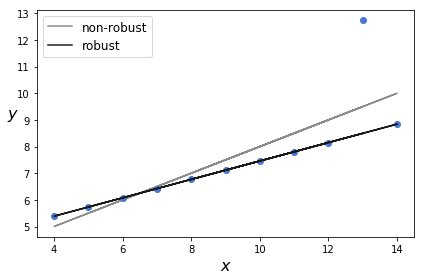

In [42]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'bo')
alpha_m = trace_t['alpha'].mean()
beta_m = trace_t['beta'].mean()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=2, fontsize=12)
plt.tight_layout()

## Hierarchical linear regression

In [43]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

print('alpha and beta are drawn from the same distributions justifying the use of hierarchical models')
alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m  + eps_real

print('alpha of each group:\n {}'.format(alpha_real))
print('beta of each group:\n {}'.format(beta_real))
print('Indices of the groups to identify each point in x_m and y_m:\n {}'.format(idx))

alpha and beta are drawn from the same distributions justifying the use of hierarchical models
alpha of each group:
 [2.58 2.89 2.93 2.15 2.03 2.94 2.39 2.69]
beta of each group:
 [0.89 0.96 0.88 0.79 0.78 0.7  0.92 0.94]
Indices of the groups to identify each point in x_m and y_m:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7]


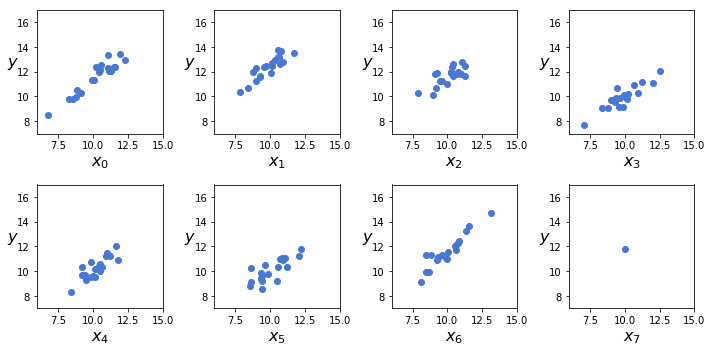

In [44]:
plt.figure(figsize=(10,5))
j, k = 0, N
for i in range(M):
    plt.subplot(2,4,i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlabel('$x_{}$'.format(i), fontsize=16)
    plt.ylabel('$y$', fontsize=16, rotation=0)
    plt.xlim(6, 15)
    plt.ylim(7, 17)
    j += N
    k += N
plt.tight_layout()

In [45]:
# center data
x_centered = x_m - x_m.mean()

#### Non-hierarchical model

In [46]:
with pm.Model() as unpooled_model:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10, shape=M)
    beta = pm.Normal('beta', mu=0, sd=10, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)

    y_pred = pm.StudentT('y_pred', mu= alpha_tmp[idx] + beta[idx] * x_centered, 
                         sd=epsilon, nu=nu, observed=y_m)

    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean()) 
    
#     start = pm.find_MAP()
    step = pm.NUTS()# scaling=start
    trace_up = pm.sample(2000, step=step, chains=1,njobs=1)

Sequential sampling (1 chains in 1 job)
NUTS: [nu, epsilon, beta, alpha_tmp]
100%|██████████| 2500/2500 [00:04<00:00, 558.31it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


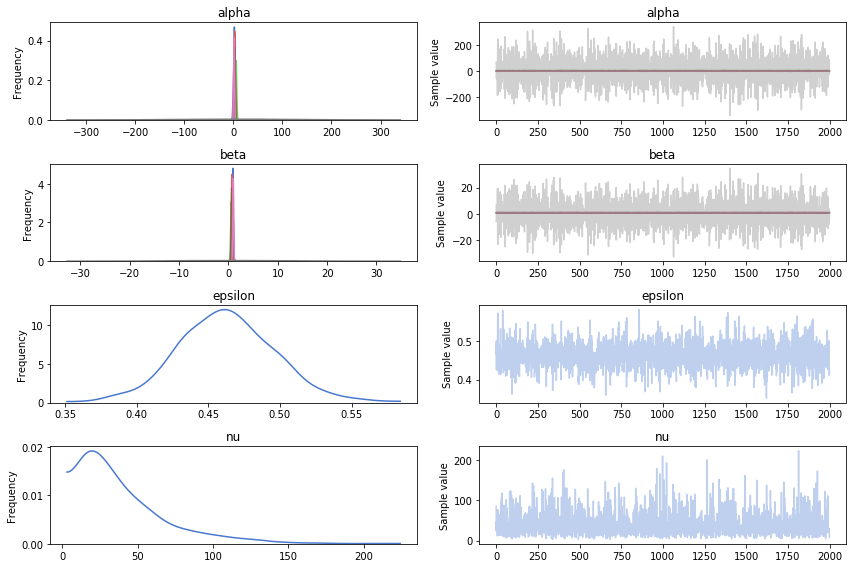

In [47]:
varnames=['alpha', 'beta', 'epsilon', 'nu']
_=pm.traceplot(trace_up, varnames)

#### we can see that everything is converging except one $\beta$ and one $\alpha$

In [48]:
# pm.autocorrplot(trace_up, varnames);

In [49]:
pm.summary(trace_up, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,2.42,0.80,1.13e-02,0.91,3.95
alpha__1,3.70,1.16,1.77e-02,1.42,6.00
alpha__2,5.63,1.30,2.22e-02,3.08,8.17
alpha__3,3.04,0.87,1.36e-02,1.22,4.63
alpha__4,1.29,1.35,2.12e-02,-1.36,3.95
alpha__5,3.22,1.03,1.56e-02,1.29,5.15
alpha__6,1.74,0.92,1.55e-02,-0.05,3.45
alpha__7,8.47,104.36,1.40e+00,-186.40,215.11
beta__0,0.90,0.08,1.10e-03,0.74,1.04
beta__1,0.88,0.12,1.81e-03,0.64,1.10


#### note the massive sd on $\alpha_{7}$ $\beta_{7}$

In [50]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    alpha_tmp_mu = pm.Normal('alpha_tmp_mu', mu=0, sd=10)
    alpha_tmp_sd = pm.HalfNormal('alpha_tmp_sd', 10)
    beta_mu = pm.Normal('beta_mu', mu=0, sd=10)
    beta_sd = pm.HalfNormal('beta_sd', sd=10)
    
    # priors
    alpha_tmp = pm.Normal('alpha_tmp', mu=alpha_tmp_mu, sd=alpha_tmp_sd, shape=M)
    beta = pm.Normal('beta', mu=beta_mu, sd=beta_sd, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)

    y_pred = pm.StudentT('y_pred', mu=alpha_tmp[idx] + beta[idx] * x_centered, 
                         sd=epsilon, nu=nu, observed=y_m)

    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean()) 
    alpha_mu = pm.Deterministic('alpha_mu', alpha_tmp_mu - beta_mu * x_m.mean())
    alpha_sd = pm.Deterministic('alpha_sd', alpha_tmp_sd - beta_mu * x_m.mean())
    # use advi instead of MAP to provide initial values
    trace_hm = pm.sample(1000, advi_map=True, chains=8, njobs=8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [nu, epsilon, beta, alpha_tmp, beta_sd, beta_mu, alpha_tmp_sd, alpha_tmp_mu]
Sampling 8 chains: 100%|██████████| 12000/12000 [00:10<00:00, 1154.97draws/s]
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 265 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5052073665905551, but should be close to 0.8. Try to increase the num

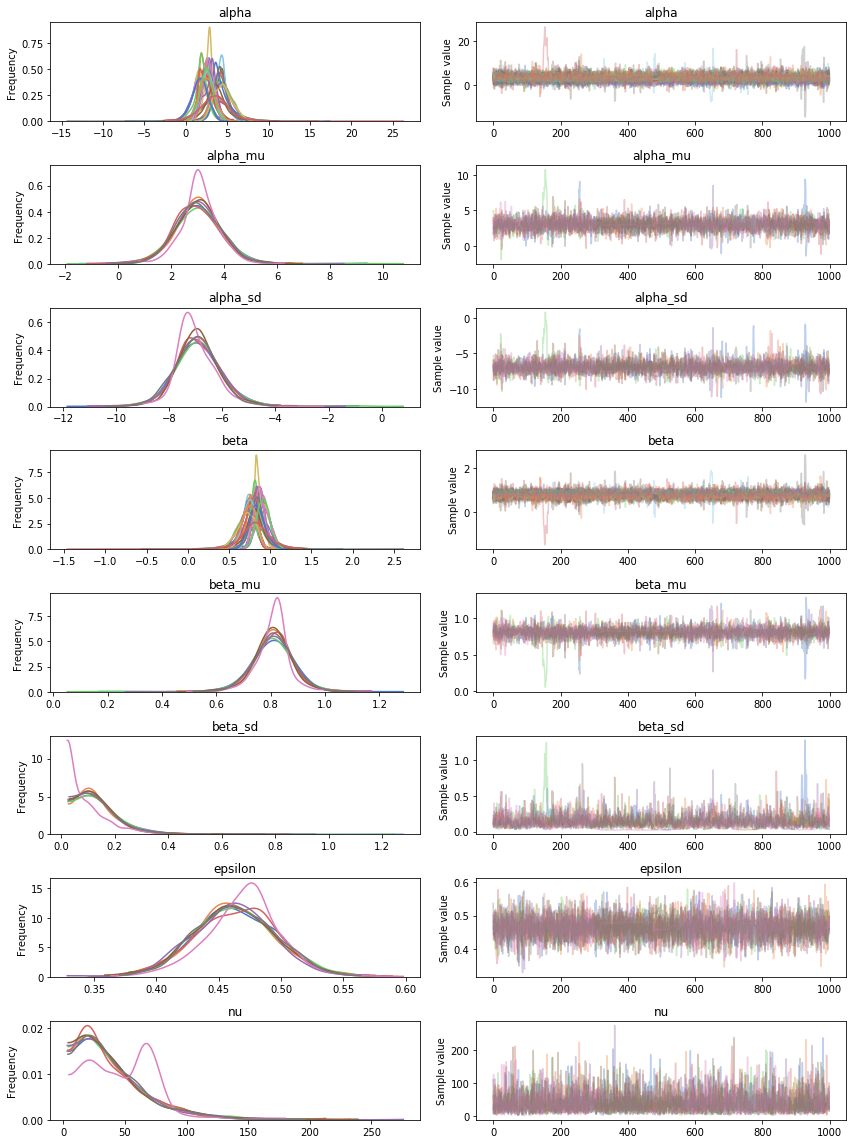

In [51]:
varnames=['alpha', 'alpha_mu', 'alpha_sd', 'beta', 'beta_mu', 'beta_sd', 'epsilon', 'nu']
_=pm.traceplot(trace_hm, varnames)

In [52]:
pm.summary(trace_hm, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,2.73,0.69,1.10e-02,1.42,4.11,5159.06,1.00
alpha__1,4.05,0.87,1.14e-02,2.29,5.81,7756.94,1.00
alpha__2,4.48,1.06,2.63e-02,2.50,6.54,1032.73,1.01
alpha__3,2.60,0.78,1.82e-02,1.13,4.16,1331.37,1.01
alpha__4,1.69,0.94,1.35e-02,-0.20,3.53,6819.79,1.00
alpha__5,2.61,0.89,2.18e-02,1.04,4.43,1186.52,1.00
alpha__6,2.48,0.84,2.42e-02,0.86,4.13,900.70,1.01
alpha__7,3.56,2.02,3.16e-02,-0.72,7.32,3242.79,1.00
alpha_mu,3.01,0.88,1.62e-02,1.36,4.78,3415.33,1.00
alpha_sd,-6.92,0.88,1.75e-02,-8.57,-5.15,2858.37,1.00


#### note the the reduced sd on $\alpha_{7}$ $\beta_{7}$ compared to non-hierarchical model

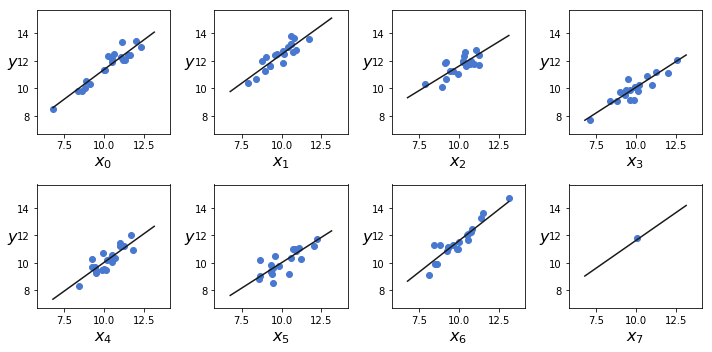

In [53]:
plt.figure(figsize=(10,5))
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    plt.subplot(2,4,i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlabel('$x_{}$'.format(i), fontsize=16)
    plt.ylabel('$y$', fontsize=16, rotation=0)
    alfa_m = trace_hm['alpha'][:,i].mean()
    beta_m = trace_hm['beta'][:,i].mean()
    plt.plot(x_range, alfa_m + beta_m * x_range, c='k', label='y = {:.2f} + {:.2f} * x'.format(alfa_m, beta_m))
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
plt.tight_layout()

## Polynomial regression

Text(0, 0.5, '$y$')

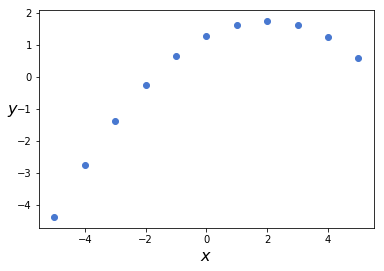

In [54]:
ans = sns.load_dataset('anscombe')
x_2 = ans[ans.dataset == 'II']['x'].values
y_2 = ans[ans.dataset == 'II']['y'].values
x_2 = x_2 - x_2.mean()
y_2 = y_2 - y_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)

In [55]:
with pm.Model() as model_poly:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=1)
    beta2 = pm.Normal('beta2', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + beta1 * x_2 + beta2 * x_2**2
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_2)

#     start = pm.find_MAP()
    step = pm.NUTS()# scaling=start
    trace_poly = pm.sample(2000, step=step, chains=1, njobs=1)

Sequential sampling (1 chains in 1 job)
NUTS: [epsilon, beta2, beta1, alpha]
100%|██████████| 2500/2500 [00:03<00:00, 659.32it/s]
The acceptance probability does not match the target. It is 0.9025982952476729, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


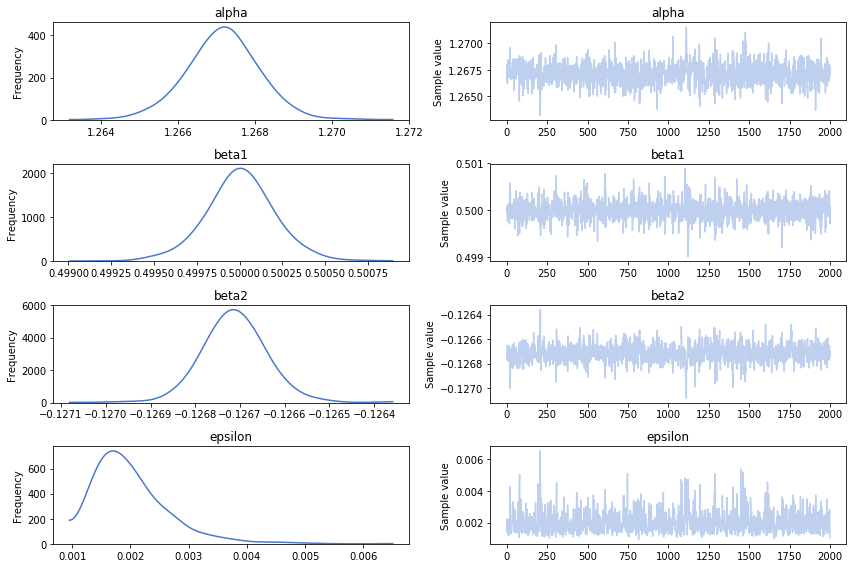

In [56]:
pm.traceplot(trace_poly);

In [57]:
pm.summary(trace_poly)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,1.27e+00,9.49e-04,3.19e-05,1.27e+00,1.27e+00
beta1,5.00e-01,2.01e-04,5.54e-06,5.00e-01,5.00e-01
beta2,-1.27e-01,7.04e-05,2.38e-06,-1.27e-01,-1.27e-01
epsilon,2.02e-03,6.39e-04,2.41e-05,1.11e-03,3.29e-03


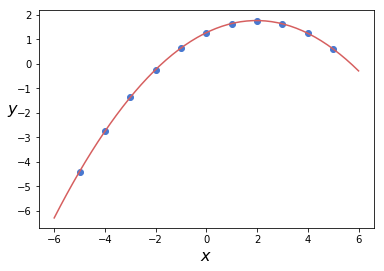

In [58]:
x_p = np.linspace(-6, 6)
y_p = trace_poly['alpha'].mean() + trace_poly['beta1'].mean() * x_p + trace_poly['beta2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x_p, y_p, c='r')

## Multiple Linear regression

In [59]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i,j in zip([10, 2], [1, 1.5])])
X_mean = X.mean(axis=1, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(beta_real, X) + eps_real
print('The features (independent variable) are across the columns. A sample:\n {}'.format(X_centered[:,:5]))

The features (independent variable) are across the columns. A sample:
 [[ 0.06 -1.66 -0.21 -0.12  0.53]
 [ 1.38  0.85 -1.49  0.2  -0.38]]


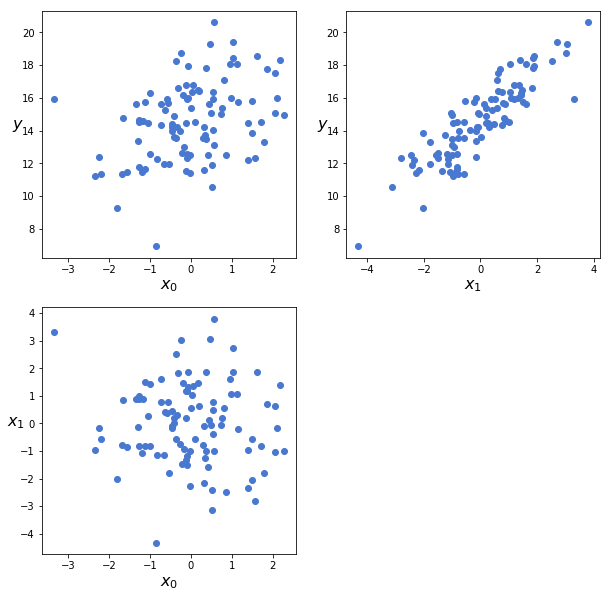

In [60]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel('$x_{}$'.format(idx), fontsize=16)
        plt.ylabel('$y$', rotation=0, fontsize=16)

    plt.subplot(2, 2, idx+2)
    plt.scatter(x[0], x[1])
    plt.xlabel('$x_{}$'.format(idx-1), fontsize=16)
    plt.ylabel('$x_{}$'.format(idx), rotation=0, fontsize=16)

scatter_plot(X_centered, y)

In [61]:
with pm.Model() as model_mlr:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=2)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha_tmp + pm.math.dot(beta, X_centered)

    alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(beta, X_mean)) 

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

#     start = pm.find_MAP()
    step = pm.NUTS() #scaling=start
    trace_mlr = pm.sample(5000, step=step, chains=1, njobs=1)

Sequential sampling (1 chains in 1 job)
NUTS: [epsilon, beta, alpha_tmp]
100%|██████████| 5500/5500 [00:03<00:00, 1485.37it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


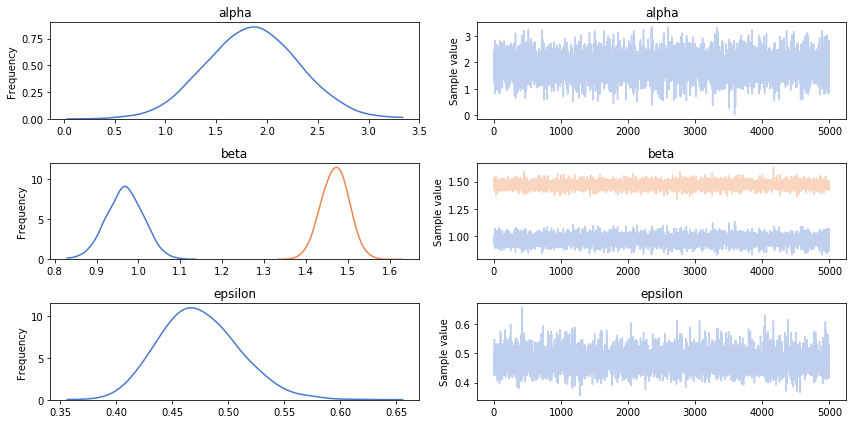

In [62]:
varnames = ['alpha', 'beta','epsilon']
pm.traceplot(trace_mlr, varnames);

In [63]:
pm.summary(trace_mlr, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,1.86,0.45,5.91e-03,0.98,2.75
beta__0,0.97,0.04,5.55e-04,0.88,1.05
beta__1,1.47,0.03,4.05e-04,1.40,1.53
epsilon,0.47,0.04,4.74e-04,0.41,0.54


## Confounding variables and redundant variables

In [64]:
np.random.seed(314)
N = 100
x_1 = np.random.normal(size=N)
# x_2 = x_1 + np.random.normal(size=N, scale=1) lower correlation case
x_2 = x_1 + np.random.normal(size=N, scale=0.01)  
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2))

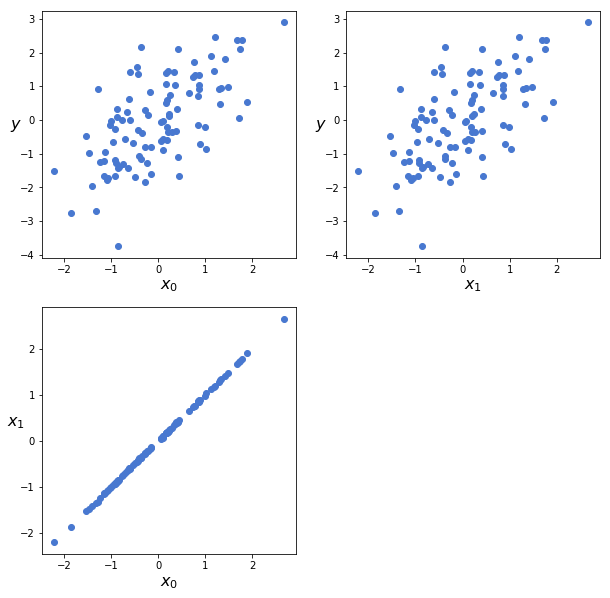

In [65]:
scatter_plot(X, y)

In [66]:
with pm.Model() as model_red:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    #beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, X)
    #mu = alpha + beta * X[0]
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
 
#     start = pm.find_MAP()
    step = pm.NUTS()#scaling=start
    trace_red = pm.sample(5000, step=step, chains=1, njobs=1)

Sequential sampling (1 chains in 1 job)
NUTS: [epsilon, beta, alpha]
100%|██████████| 5500/5500 [01:30<00:00, 67.64it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


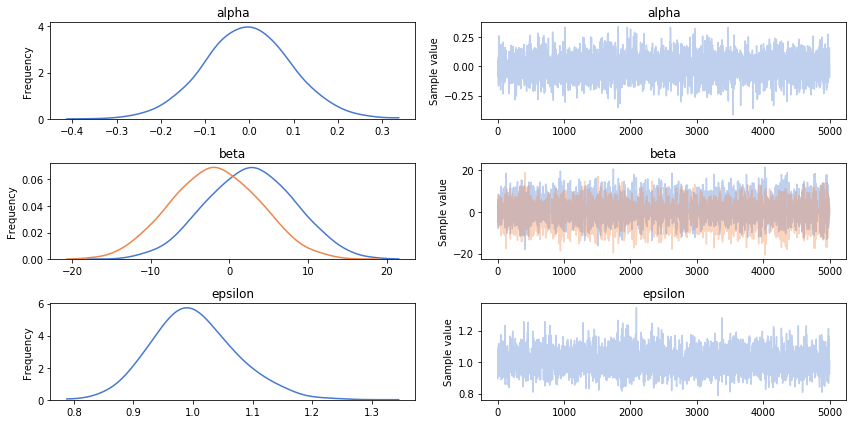

In [67]:
pm.traceplot(trace_red);

In [68]:
pm.summary(trace_red)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-3.67e-03,0.10,1.82e-03,-0.20,0.19
beta__0,2.67e+00,5.59,1.29e-01,-7.42,14.26
beta__1,-1.77e+00,5.57,1.29e-01,-13.08,8.51
epsilon,1.00e+00,0.07,1.39e-03,0.87,1.15


Text(0, 0.5, '$\\beta_2$')

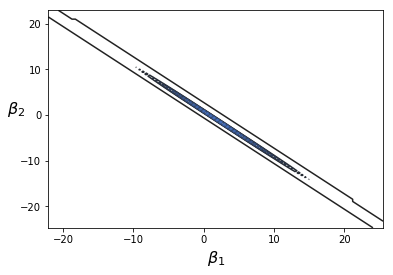

In [69]:
sns.kdeplot(trace_red['beta'][:,0], trace_red['beta'][:,1])
plt.xlabel(r'$\beta_1$', fontsize=16)
plt.ylabel(r'$\beta_2$', fontsize=16, rotation=0)

GridSpec(1, 1)

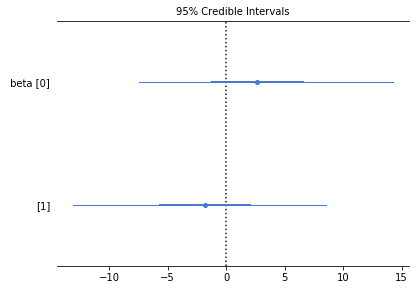

In [70]:
pm.forestplot(trace_red, varnames=['beta'])

#### When two variables are highly correlated they are masking the effects of each other
We can: 
- Eliminate a variable
- Combine them (average them, PCA)
- Add stronger priors, i.e. regularizing priors that restric the plausible values the coefficient can take

## Masking effect variables
In this case the dependent variable $y$ is the difference of two correlated varaibles and omitting one from the analysis will be a mistake since their individual effects are negligible.  

In [71]:
np.random.seed(314)
N = 100
r = 0.8
x_0 = np.random.normal(size=N)
x_1 = np.random.normal(loc=x_0 * r, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(loc=x_0 - x_1)
X = np.vstack((x_0, x_1))

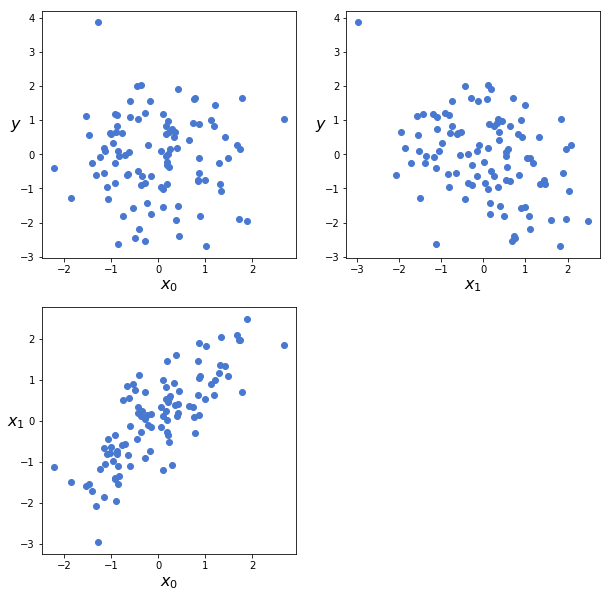

In [72]:
scatter_plot(X, y)

In [73]:
with pm.Model() as model_ma:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    #beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, X)
    #mu = alpha + beta * X[0]

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

#     start = pm.find_MAP()
    step = pm.NUTS() # scaling=start
    trace_ma = pm.sample(5000, step=step, chains=1, njobs = 1)

Sequential sampling (1 chains in 1 job)
NUTS: [epsilon, beta, alpha]
100%|██████████| 5500/5500 [00:04<00:00, 1207.37it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


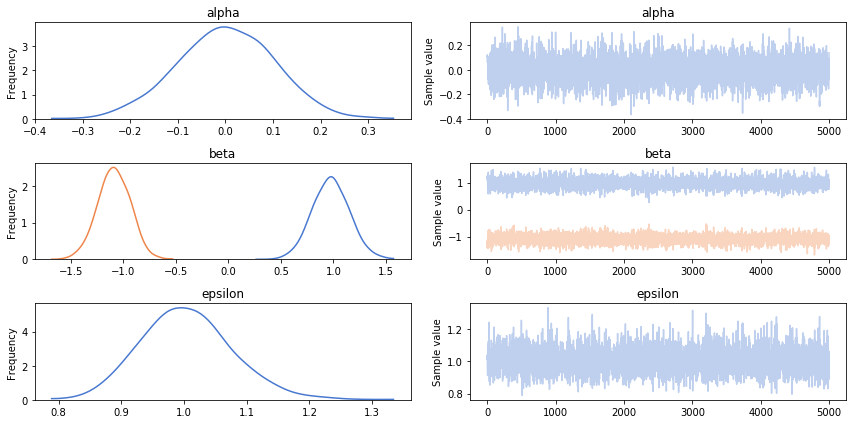

In [74]:
pm.traceplot(trace_ma);

In [75]:
pm.summary(trace_ma)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,1.29e-03,0.10,1.71e-03,-0.20,0.19
beta__0,9.75e-01,0.18,2.53e-03,0.62,1.32
beta__1,-1.09e+00,0.15,2.32e-03,-1.38,-0.78
epsilon,1.00e+00,0.07,1.03e-03,0.87,1.15


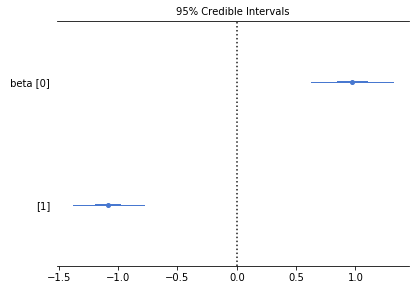

In [76]:
pm.forestplot(trace_ma, varnames=['beta']);

In [77]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a %s computer running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\nPandas %s" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__, pd.__version__))

This notebook was created on a x86_64 computer running debian buster/sid and using:
Python 3.7.2
IPython 7.2.0
PyMC3 3.6
NumPy 1.16.0
SciPy 1.2.0
Matplotlib 3.0.2
Seaborn 0.9.0
Pandas 0.23.4


/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  
